# Files for 2024-10-29 to 2024-11-01 observing session
Priorities for this session:
* Continue to double the exposure time returned by the PEPSI ETC in hopes of getting good SNR
* Prioritize systems that weren't resolved with DSSI measurements from APO
* Get multiple RV measurements on a systems for which we already have LBT spectra


In [13]:
from functools import partial
import importlib
from sqlite3 import connect
import sys

import astroplan as ap
from astropy.coordinates import SkyCoord, get_body, EarthLocation
from astropy.table import Table
from astropy.time import Time
import astropy.units as u
import numpy as np
import pandas as pd

sys.path.append("../../")
import astropaul.targetlistcreator as tlc
import astropaul.lbt as lbt

importlib.reload(tlc)
importlib.reload(lbt)

<module 'astropaul.lbt' from 'c:\\Users\\User\\Dropbox\\Astro\\Other\\2024-10-21 LBT Observing\\../..\\astropaul\\lbt.py'>

In [23]:
# start by making list of targets from 2024B proposal that are observable and have prior spectra
conn = connect("../../django/TargetDB/db.sqlite3")

observer = ap.Observer.at_site("LBT", timezone="US/Arizona")
# session = (Time("2024-10-29"), Time("2024-11-02"))
session = (
    observer.sun_set_time(Time("2024-10-30"), which="next", horizon=-6*u.deg),
    observer.sun_rise_time(Time("2024-11-02"), which="next", horizon=-6*u.deg),
)

creator = tlc.TargetListCreator(connection=conn)
creator.steps = [
    tlc.add_targets,
    tlc.add_tess,
    tlc.add_coords,
    partial(tlc.hide_cols, prefix="tess"),
    tlc.add_lists,
    tlc.add_spectra,
    partial(lbt.add_pepsi_params, fiber="300", cd_blue=3, cd_red=6, snr=100, binocular=False),
    partial(
        tlc.add_observability,
        observer=observer,
        time_segment= Time("2024-10-30 01:50"),
    ),
]
targets = creator.calculate()
# targets = Table.from_pandas(creator.calculate())

criteria = (targets["list_LBT_2024B"]) & (targets["pepsi_count"] > 0) & (targets["observable"])
lbt_targets = targets.loc[criteria]
lbt_targets.sort_values(by=["ra"], inplace=True)

# double the exposure time and convert from seconds to minutes
lbt_targets.loc[:, "pepsi_exp_time"] *= 2
lbt_targets.loc[:, "pepsi_exp_time"] /= 60

# prioritize targets unresolved by APO speckle
# lbt_targets.loc[:, "pepsi_priority"] = "Normal"
# lbt_targets.loc[lbt_targets["list_HQND"], "pepsi_priority"] = "High"

Table.from_pandas(lbt_targets)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\erfa\core.py:4620: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\erfa\core.py:19004: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\erfa\core.py:4036: RuntimeWarning: invalid value encountered in atioq
  aob, zob, hob, dob, rob = ufunc.atioq(ri, di, astrom)
C:\Users\User\AppData\Local\Temp\ipykernel_11724\2365752889.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lbt_targets.sort_values(by=["ra"], inplace=True)


target_name,target_source,target_type,ra,dec,pmra,pmdec,parallax,Vmag,Teff,RA,Dec,list_Featured_targets,list_Gemini_2024B_Proposal,list_Gemini_2025A_Proposal,list_HQND,list_Kostov_2022,list_Kostov_2023,list_LBT_2023-12-06,list_LBT_2023B,list_LBT_2024B,list_Speckle_Resolved,pepsi_count,pepsi_fiber,pepsi_cd_blue,pepsi_cd_blue_num_exp,pepsi_cd_red,pepsi_cd_red_num_exp,pepsi_snr,pepsi_exp_time,pepsi_priority,pepsi_notes,observable
str13,str28,str6,float64,float64,float64,float64,float64,float64,float64,str11,str12,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,str3,int64,int64,int64,int64,int64,float64,str1,str1,bool
TIC 283940788,Kostov 2022 arXiv:2202.05790,QuadEB,8.85143612777593,62.9015955605648,-2.72664,-0.153866,0.076539,11.774,7384.0,0:35:24.34,+62:54:05.74,False,False,False,False,True,False,True,True,True,True,6,300,3,1,6,1,100,9.716666666666667,,,True
TIC 307119043,Kostov 2022 arXiv:2202.05790,QuadEB,14.8275237070873,51.2216426597246,7.56019,-4.10877,2.1988,9.94,7815.0,0:59:18.61,+51:13:17.91,True,False,False,False,True,False,True,True,True,True,6,300,3,1,6,1,100,1.7933333333333332,,,True
TIC 52856877,Kostov 2022 arXiv:2202.05790,QuadEB,17.3342875541794,61.0412445618326,3.21705,-1.71955,1.07133,10.969,8886.0,1:09:20.23,+61:02:28.48,False,True,False,True,True,False,True,True,True,False,2,300,3,1,6,1,100,6.506666666666666,,,True
TIC 389836747,Kostov 2022 arXiv:2202.05790,QuadEB,23.2954696490378,61.585307417502,-6.6,-2.4,--,10.718,8874.0,1:33:10.91,+61:35:07.11,False,False,False,False,True,False,True,True,True,True,6,300,3,1,6,1,100,5.163333333333333,,,True
TIC 123098844,Kostov 2022 arXiv:2202.05790,QuadEB,279.57284311725,44.6986003104844,3.4825,-9.10427,1.30925,11.136,6761.0,18:38:17.48,+44:41:54.96,False,True,False,True,True,False,True,True,True,False,4,300,3,1,6,1,100,4.683333333333334,,,True
TIC 89278612,Kostov 2022 arXiv:2202.05790,QuadEB,301.21949809707,32.6430514778645,-0.48521,-1.50692,0.663315,11.235,8740.0,20:04:52.68,+32:38:34.99,True,False,False,False,True,False,True,True,True,True,6,300,3,1,6,1,100,8.31,,,True
TIC 278352276,Kostov 2022 arXiv:2202.05790,QuadEB,307.503640407431,48.6070563353721,1.85387,6.57664,1.36265,10.387,7156.0,20:30:00.87,+48:36:25.40,False,True,True,True,True,False,True,True,True,False,4,300,3,1,6,1,100,2.4733333333333336,,,True
TIC 322727163,Kostov 2022 arXiv:2202.05790,QuadEB,309.716625434398,50.466820684196,2.8,-7.5,--,10.997,7876.56,20:38:51.99,+50:28:00.55,False,False,False,False,True,False,True,True,True,True,8,300,3,1,6,1,100,6.09,,,True
TIC 375325607,Kostov 2022 arXiv:2202.05790,QuadEB,315.793095381608,55.4693137447543,--,--,--,12.682,--,21:03:10.34,+55:28:09.53,False,False,False,False,True,False,True,True,True,True,8,300,3,1,6,1,100,15.936666666666667,,,True


In [24]:
final_targets = Table.from_pandas(lbt_targets)
final_targets["target_name"].info.format = "<14s"
final_targets["Teff"].info.format = ".0f"
final_targets["pepsi_exp_time"].info.format = ".2f"

foo = lbt.write_lbt_readme_file("UVa_Multistar", final_targets)
print(foo)

Project ID: UV-2024B-007
     Title: Characterizing Quadruple and Sextuple Eclipsing Binaries with PEPSI

Instrument: PEPSI PFU

PI: Steven Majewski

Run Contact:
   Name: Steven Majewski (UVA) / Robert Wilson (NASA)
   Phone: srm4n@virginia.edu   / 210.487.0187
   Contact Times: all / all

Conditions Required:
   Moon: Any
   Desired Seeing: Any
   Cloud Cover: Any

Program Summary:

Targets are TESS identified eclipsing quadruple systems (2 sets of Eclipsing Binaries, each showing both a Primary and Secondary Eclipse).

There are two objectives for this run:
1) Better understand the relation between exposure times from the PEPSI exposure time calculator vs the quality of spectra obtained.
2) Accumulate spectra towards the goal of using radial velocity measurements to characterize the orbital dynamics of the systems.

 Target Name        RA         Dec       Vmag  Teff Fiber BLUE Cross Disperser BLUE CD NExp BLUE CD Exp Time RED Cross Disperser RED CD NExp RED CD Exp Time Desired BLUE

# Make a priority chart of targets by observing hour

In [14]:
# create list of observing times we care about
chart_cadence = 1 * u.hour
observing_times, observing_utcs = [], []
observing_day = session[0]
while observing_day <= session[1]:
    observing_time = observer.twilight_evening_astronomical(observing_day).datetime
    observing_time = Time(pd.Timestamp(observing_time).round("60min"))  # round to nearest hour
    observing_end = observer.twilight_morning_astronomical(observing_day, which="next")
    while observing_time < observing_end:
        observing_times.append(observing_time)
        observing_utcs.append(observing_time.to_value(format="iso", subfmt="date_hm"))
        observing_time += chart_cadence
    observing_day += 1 * u.day

# prepare tables that will hold scores for each target
factor_tables = {
    target_name: Table({"Time": observing_times, "UTC": observing_utcs}) for target_name in lbt_targets["target_name"]
}

# make dictionary of ephemerides by target
systems = ["A", "B"]
ephem_table = tlc.add_ephemerides(lbt_targets.copy(), connection=conn)[
    ["target_name", "ephem_system", "ephem_member", "ephem_t0", "ephem_period", "ephem_duration"]
]
from collections import defaultdict

ephemerides = defaultdict(dict)
for target_name in lbt_targets["target_name"]:
    for system in systems:
        ephemerides[target_name][system] = tuple(
            ephem_table[
                (ephem_table["target_name"] == target_name)
                & (ephem_table["ephem_system"] == system)
                & (ephem_table["ephem_member"] == "a")
            ][["ephem_t0", "ephem_period"]].values[0]
        )

# for each target/time, categorize each 'a' member of each system based on its phase
# T=transverse motion, B=both, R=radial motion
phase_labels = [
    ((0.00, 0.05), "T"),
    ((0.05, 0.18), "B"),
    ((0.18, 0.32), "R"),
    ((0.32, 0.45), "B"),
    ((0.45, 0.55), "T"),
    ((0.55, 0.68), "B"),
    ((0.68, 0.82), "R"),
    ((0.82, 0.95), "B"),
    ((0.95, 1.00), "T"),
]
for target_name in lbt_targets["target_name"]:
    factor_table = factor_tables[target_name]
    for system in systems:
        system_factors = []
        for observing_time in factor_table["Time"]:
            t0, period = ephemerides[target_name][system]
            phase = float((observing_time.jd - t0) / period) % 1
            for (lo, hi), label in phase_labels:
                if lo <= phase < hi:
                    system_factors.append(label)
                    break
        factor_table[f"Phase {system}"] = system_factors
# favor targets with radial motion in one system and transverse in the other
# penalize targets with both systems in eclipse
phase_scores = [
    (("R", "T"), 1),
    (("T", "R"), 1),
    (("R", "B"), 0.5),
    (("B", "R"), 0.5),
    (("B", "T"), 0.5),
    (("T", "B"), 0.5),
    (("T", "T"), -1),
]
for target_name in lbt_targets["target_name"]:
    factor_table = factor_tables[target_name]
    moon_factors = []
    for row in factor_table:
        factor = 0
        phases = list(row[["Phase A", "Phase B"]])
        for (a, b), score in phase_scores:
            if phases == [a, b]:
                factor = score
                break
        moon_factors.append(factor)
    factor_table["Phase Factor"] = moon_factors

# give bonus for targets in HQND list
for target_name, factor_table in factor_tables.items():
    hqnd = lbt_targets[lbt_targets["target_name"] == target_name]["list_HQND"].any()
    factor_table["HQND Factor"] = 1.0 if hqnd else 0.0

# evaluate targets' proximity to the moon and height in the sky
moon_scores = [
    ((0, 30), -1.0),
    ((30, 60), 0.0),
    ((60, 180), 1.0),
]
altitude_scores = [
    ((-90, 30), -10),
    ((30, 45), -0.5),
    ((45, 60), 0),
    ((60, 90), 1),
]
location = EarthLocation.of_site("LBT")
for target_name, factor_table in factor_tables.items():
    ra, dec = lbt_targets[lbt_targets["target_name"] == target_name][["ra", "dec"]].values[0]
    target = SkyCoord(ra=ra, dec=dec, unit=u.deg)
    moon_factors, altitudes, altitude_factors = [], [], []
    for row in factor_table:
        time = row["Time"]
        moon = get_body(body="moon", time=time, location=location)
        # moon = observer.moon_altaz(time)
        distance = target.separation(moon).value
        for (lo, hi), score in moon_scores:
            if lo <= distance < hi:
                moon_factors.append(score)
                break
        altitude = observer.altaz(time, target).alt.value
        altitudes.append(altitude)
        for (lo, hi), score in altitude_scores:
            if lo <= altitude < hi:
                altitude_factors.append(score)
                break
    factor_table["Moon Factor"] = moon_factors
    factor_table["Altitude"] = altitudes
    factor_table["Altitude Factor"] = altitude_factors

In [15]:
# from the individual factors generate an overall factor
# put the results into a new table with columns for each target
target_factors = Table({"Time": observing_utcs})
for target_name, factor_table in factor_tables.items():
    factor_table["Final Factor"] = (0
        + 2.0 * factor_table["Phase Factor"]
        + 1.0 * factor_table["HQND Factor"]
        + 0.0 * factor_table["Moon Factor"]
        + 0.5 * factor_table["Altitude Factor"]
    )
    target_factors[target_name] = factor_table["Final Factor"]

target_factors.pprint_all()

all_factors = pd.Series(np.hstack(target_factors[target_factors.colnames[1:]].as_array().tolist()))
all_factors.value_counts().sort_index(ascending=False).to_dict()

      Time       TIC 283940788 TIC 307119043 TIC 52856877 TIC 389836747 TIC 123098844 TIC 89278612 TIC 278352276 TIC 322727163 TIC 375325607 TIC 427092089 TIC 414026507 TIC 25818450 TIC 470710327
---------------- ------------- ------------- ------------ ------------- ------------- ------------ ------------- ------------- ------------- ------------- ------------- ------------ -------------
2024-10-30 02:00           0.0          -2.0         0.75          1.75           2.0         -1.5           2.5           2.5           1.5           2.0           1.5         -2.0           1.0
2024-10-30 03:00           1.0           1.0          1.0           2.0           2.0          1.5           2.5           1.5           2.5           2.0           1.5         -1.5           1.0
2024-10-30 04:00           1.0           0.5          1.0           2.0          1.75          0.0           2.0           0.0           1.0           2.0           1.5          1.5           0.5
2024-10-30 05:00    

{3.5: 2,
 3.0: 7,
 2.75: 2,
 2.5: 25,
 2.0: 52,
 1.75: 29,
 1.5: 36,
 1.0: 66,
 0.75: 35,
 0.5: 31,
 0.0: 39,
 -0.25: 36,
 -1.5: 3,
 -2.0: 6,
 -2.25: 3,
 -3.0: 40,
 -4.0: 97,
 -5.0: 57,
 -6.0: 4,
 -7.0: 2}

In [16]:
target_priorities = target_factors.copy()
target_priorities.add_columns(
    [[date[:10] for date in target_priorities["Time"]], [time[11:] for time in target_priorities["Time"]]],
    names=["Date", "Time UTC"],
    indexes=[0, 1],
)
target_priorities.remove_column("Time")

# apply categories based on the numerical range of the factors
bins = [np.min(all_factors), 0, 1.5, 2.0, np.max(all_factors)]
# labels = ["", "+", "+++", "+++++"]
labels = ["", "Low", "Normal", "High"]
for target_name in lbt_targets["target_name"]:
    target_priorities[target_name] = pd.cut(target_priorities[target_name], bins=bins, labels=labels, ordered=False, include_lowest=True)

# add coordinates to make the operator's life easier
target_priorities.add_row(
    ["", "RA J2000"]
    + [
        lbt_targets[lbt_targets["target_name"] == target_name]["RA"].values[0][:-3]
        for target_name in target_factors.colnames[1:]
    ]
)
target_priorities.add_row(
    ["", "Dec J2000"]
    + [
        lbt_targets[lbt_targets["target_name"] == target_name]["Dec"].values[0][:-3]
        for target_name in target_factors.colnames[1:]
    ]
)

target_priorities.write("Target Priorities.csv", overwrite=True)
target_priorities  # .pprint_all()

Date,Time UTC,TIC 283940788,TIC 307119043,TIC 52856877,TIC 389836747,TIC 123098844,TIC 89278612,TIC 278352276,TIC 322727163,TIC 375325607,TIC 427092089,TIC 414026507,TIC 25818450,TIC 470710327
str10,str9,object,object,object,object,object,object,object,object,object,object,object,object,object
2024-10-30,02:00,,,Low,Normal,Normal,,High,High,Low,Normal,Low,,Low
2024-10-30,03:00,Low,Low,Low,Normal,Normal,Low,High,Low,High,Normal,Low,,Low
2024-10-30,04:00,Low,Low,Low,Normal,Normal,,Normal,,Low,Normal,Low,Low,Low
2024-10-30,05:00,Normal,Low,Low,Normal,,,Normal,,Low,Low,Low,Low,Low
2024-10-30,06:00,Normal,Low,Low,Low,,,Low,Low,Low,Low,Low,Low,
2024-10-30,07:00,Low,Low,Low,Low,,,,,,Low,Low,Low,
2024-10-30,08:00,Low,,Low,,,,,,,,Low,Low,Low
2024-10-30,09:00,Low,,Low,,,,,,,,,Low,Low
2024-10-30,10:00,,,Low,,,,,,,,,,


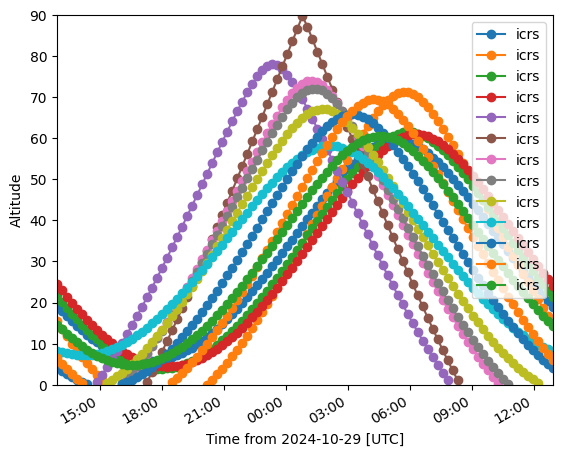

In [8]:
from astroplan.plots import plot_altitude
import matplotlib.pyplot as plt

for ra, dec in lbt_targets[["ra", "dec"]].values:
    target = SkyCoord(ra=ra, dec=dec, unit=u.deg)
    plot_altitude(target, observer, session[0])

plt.legend(loc=1, bbox_to_anchor=(1, 1))
plt.show()